# Reading Sentinel 1 features through STAC

In [1]:
from datetime import datetime
import os

import boto3
from dotenv import load_dotenv
import geopandas as gpd
from pystac_client import Client
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling
from rasterio.session import AWSSession
import rioxarray
import stackstac

## Input

Authentication

In [2]:
auth_method = "profile"
endpoint_url = "s3.lcfm-datahub.gaf.de"
if auth_method == "profile":
    profile = "gaf"
else:
    # Read s3 keys from .env files
    load_dotenv()
    os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
    os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

Query

In [10]:
shapefile = "../resources/LCFM_ONE_SAMPLE_Grids10m.geojson"
gdf_pm = gpd.read_file(shapefile)

In [11]:
from shapely.geometry import Polygon
import numpy as np

union = gdf_pm.union_all()

# Get all coordinates from the geometry exterior
coords = np.array(list(union.exterior.coords))

# Find the corners using convex hull properties
ch = union.convex_hull
ch_coords = np.array(list(ch.exterior.coords))

# Keep only the 4 most extreme points
min_x_idx = np.argmin(ch_coords[:, 0])
max_x_idx = np.argmax(ch_coords[:, 0])
min_y_idx = np.argmin(ch_coords[:, 1])
max_y_idx = np.argmax(ch_coords[:, 1])

# Get the 4 corner points
corner_indices = sorted(list(set([min_x_idx, max_x_idx, min_y_idx, max_y_idx])))

# Check if we have exactly 4 corners
if len(corner_indices) < 4:
    # Alternative approach: get the actual corners from a simplified polygon
    simplified = union.simplify(union.length / 100)  # Simplify to get fewer points
    simple_coords = np.array(list(simplified.exterior.coords))
    
    # Find points furthest from centroid
    centroid = simplified.centroid
    distances = [point.distance(centroid) for point in [Polygon([simple_coords[i:i+2]]) for i in range(len(simple_coords)-1)]]
    sorted_indices = np.argsort(distances)[-4:]  # Get 4 points furthest from centroid
    corner_points = [tuple(simple_coords[i]) for i in sorted_indices]
else:
    corner_points = [tuple(ch_coords[i]) for i in corner_indices]
print(corner_points)

# Get the centroid for initialization
centroid = union.centroid
centroid_point = (centroid.x, centroid.y)
print(centroid_point)

# Initialize points with the centroid coordinates (will be replaced by actual corners)
ul = ur = ll = lr = centroid_point

for point in corner_points:
    x, y = point
    # Upper Left (lowest x, highest y)
    if x <= ul[0] and y >= ul[1]:
        ul = point
        print(f"Upper Left: {ul}")
    # Upper Right (highest x, highest y)
    if x >= ur[0] and y >= ur[1]:
        ur = point
        print(f"Upper right: {ur}")
    # Lower Left (lowest x, lowest y)
    if x <= ll[0] and y <= ll[1]:
        ll = point
        print(f"Lower left: {ll}")
    # Lower Right (highest x, lowest y)
    if x >= lr[0] and y <= lr[1]:
        lr = point
        print(f"Lower right: {lr}")

# Create a properly ordered corner points list
corner_points = [ul, ur, lr, ll]
print(corner_points)

[(-7287217.763502375, -651331.2829349549), (-7287318.228628153, -651330.8402896702), (-7287317.78886986, -651229.7052062404), (-7287217.323904815, -651230.1477818596)]
(-7287267.776215057, -651280.4940801143)
Lower right: (-7287217.763502375, -651331.2829349549)
Lower left: (-7287318.228628153, -651330.8402896702)
Upper Left: (-7287317.78886986, -651229.7052062404)
Upper right: (-7287217.323904815, -651230.1477818596)
[(-7287317.78886986, -651229.7052062404), (-7287217.323904815, -651230.1477818596), (-7287217.763502375, -651331.2829349549), (-7287318.228628153, -651330.8402896702)]


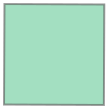

In [12]:
# Create a polygon from the corner points
polygon = Polygon(corner_points)
polygon

In [13]:
gdf_pm.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Create a gdf from the polygon
gdf = gpd.GeoDataFrame(index=[0], crs=gdf_pm.crs, geometry=[polygon])
crs_utm = gdf_pm["UTM"].iloc[0]

# Read 29TNE_shape.geojson
gdf = gdf.to_crs(crs_utm)
bounds = gdf.iloc[0].geometry.bounds
geometry_latlon = gdf.to_crs("EPSG:4326").geometry.iloc[0]

In [15]:
#shapefile = "../resources/29TNE_shape.geojson"
#crs = 32629

# Read 29TNE_shape.geojson
#gdf = gpd.read_file(shapefile).to_crs(crs)
#bounds = gdf.iloc[0].geometry.bounds
#geometry_latlon = gdf.to_crs("EPSG:4326").geometry.iloc[0]

Collection parameters

In [17]:
collection = "LCFM_LCM-10_v008"
resolution = 10

In [18]:
# Define the date range for the search
year = 2020
start_date = datetime(year, 1, 1).isoformat() + "Z"
end_date = datetime(year, 12, 12).isoformat() + "Z"

## STAC query

In [20]:
# Connect to the STAC API
stac_api_url = "https://www.stac.lcfm.dataspace.copernicus.eu/"
catalog = Client.open(stac_api_url)

# Fetch items from the collection using the search method with spatial and temporal constraints
search = catalog.search(
    collections=[collection],
    datetime=f"{start_date}/{end_date}",
    intersects=geometry_latlon,
)

items = list(search.items())

if items:
    # Print items found in the collection
    print(f"Found {len(items)} items in the collection:")
    for item in items:
        print(f"- {item.id}")
else:
    print("No items found in the collection.")


Found 2 items in the collection:
- LCFM_LCM-10_V008_2020_20MKU_MAP
- LCFM_LCM-10_V008_2020_19MHP_MAP


In [29]:
crs_utm = 32721

In [31]:
# Select item from the list with matching crs
item = None
for i in items:
    if i.properties["proj:code"] == f"EPSG:{crs_utm}":
        item = i
        break
if item:
    print(item.id)
else:
    # TODO: look for item with closest CRS which envelops the area
    print("No item found with matching CRS.")    

No item found with matching CRS.


In [32]:
# S3 session info
# If profile, pass profile_name; otherwise use keys
if auth_method == "profile":
    b3 = boto3.Session(profile_name="lcfm")
else:
    b3 = boto3.Session(
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )

aws_session = AWSSession(session=b3, endpoint_url=endpoint_url)

# 3) Tell GDAL to use path-style + your endpoint
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always={
      "session":                 aws_session,
    }
)

## Read MAP asset

In [ ]:
# Assuming 'items' is a list of STAC items you've retrieved
item = items[0]  # Using the first item for this example
assets = ["MAP"]

# Now you can use stackstac with the modified STAC item
s1_obs = stackstac.stack([item],
                          assets=assets,
                          bounds=bounds,
                          resolution=resolution,
                          epsg=crs_utm,
                          fill_value=np.uint8(255),
                          dtype=np.uint8,
                          rescale=False,
                          gdal_env=gdal_env,
                          )

# Example to check the DataArray information
# s1_obs

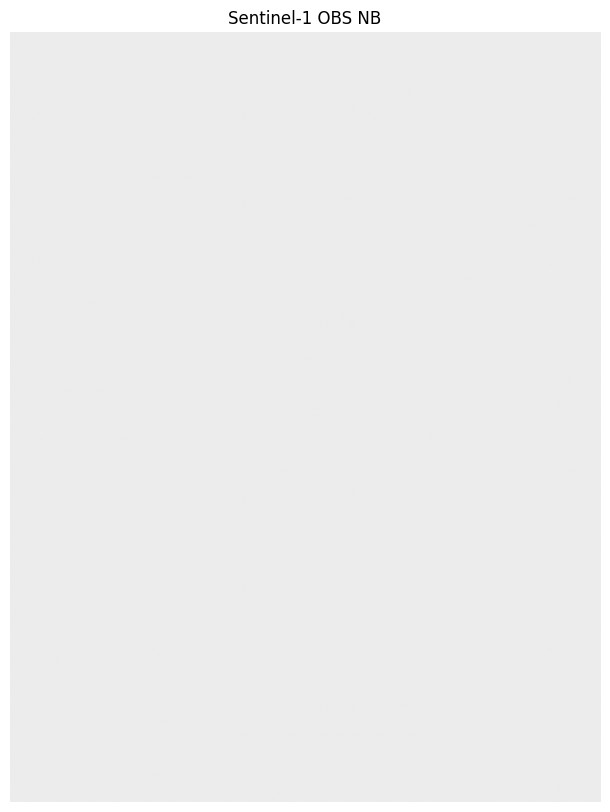

In [12]:
# Extract the bands (assuming the order is B04=0, B03=1, B02=2)
obs_nb = s1_obs.sel(band="GAMMA0-OBS-NB").values[0,:,:]

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(obs_nb, cmap='gray', vmin=0, vmax=13)  # Use 'gray' for single band
plt.title("Sentinel-1 OBS NB")
plt.axis('off')  # Hide the axis
plt.show()

In [13]:
# Write out
profile_kwargs = {
    "driver": "GTiff",
    "dtype": str(s1_obs.dtype),     # make sure your data actually fits this type
    "compress": "LZW",    # lossless LZW compression
}

output_file = "s1_data.tif"
s1_obs.name = s1_obs.band.values[0]
s1_obs.isel(time=0).rio.to_raster(output_file, **profile_kwargs)

print(f"Saved GeoTIFF → {output_file}")

Saved GeoTIFF → s1_data.tif


### Reproject

In [14]:
# reproject
obs_nb_wgs84 = s1_obs.isel(time=0).rio.reproject(
    "EPSG:4326",              # target CRS
    resolution=2*8.33333e-5,       # lon/lat degrees per pixel
    resampling=Resampling.bilinear     # or "nearest", "cubic", etc.
)

In [15]:
# Write out
profile_kwargs = {
    "driver": "GTiff",
    "dtype": str(obs_nb_wgs84.dtype),     # make sure your data actually fits this type
    "compress": "LZW",    # lossless LZW compression
}

output_file = "s1_data_4326.tif"
obs_nb_wgs84.name = obs_nb_wgs84.band.values[0]
obs_nb_wgs84.rio.to_raster(output_file, **profile_kwargs)

print(f"Saved GeoTIFF → {output_file}")

Saved GeoTIFF → s1_data_4326.tif
